# ROMS-TOOLS setup for Iceland0_MARBL_2024

First step is to set up the outer grid using ROMS-TOOLS and save the grid file.

In [4]:
import xarray as xr
from roms_tools import Grid

In [5]:
project='/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/'
datasets='/anvil/projects/x-ees250129/Datasets_subset/'
model_name='Iceland0'
child_name='Iceland1'
grid_path='/anvil/projects/x-ees250129/x-uheede/MATLAB/setup_s2r_phys+bgc/1.Make_grid/Iceland0_grid_MAT.nc'

In [15]:
#%%time

#grid = Grid(
#    nx=512,  # number of grid points in x-direction
#    ny=512,  # number of grid points in y-direction
#    size_x=1280,  # domain size in x-direction (in km)
#    size_y=1280,  # domain size in y-direction (in km)
#    center_lon=-25,  # longitude of the center of the domain
#    center_lat=63,  # latitude of the center of the domain
#    rot=-20,  # rotation of the grid (in degrees)
#    topography_source={
#        "name": "SRTM15",
#        "path":datasets+"SRTM15/SRTM15_V2.6.nc"},
#    N=100,  # number of vertical layers
#    verbose=True,
#)

In [6]:
grid = Grid.from_file(grid_path)

2025-10-14 11:57:07 - WARNING - Vertical coordinates (Cs_r, Cs_w) not found in grid file.
2025-10-14 11:57:07 - INFO - === Preparing the vertical coordinate system using N = 100, theta_s = 5.0, theta_b = 2.0, hc = 300.0 ===
2025-10-14 11:57:07 - INFO - Total time: 0.003 seconds
2025-10-14 11:57:07 - INFO - ========================================================================================================


In [17]:
#mat_grid=xr.open_dataset('/anvil/projects/x-ees250129/x-uheede/MATLAB/setup_s2r_phys+bgc/1.Make_grid/Iceland0_grid_MAT.nc')

In [18]:
#mat_grid['h'].plot()

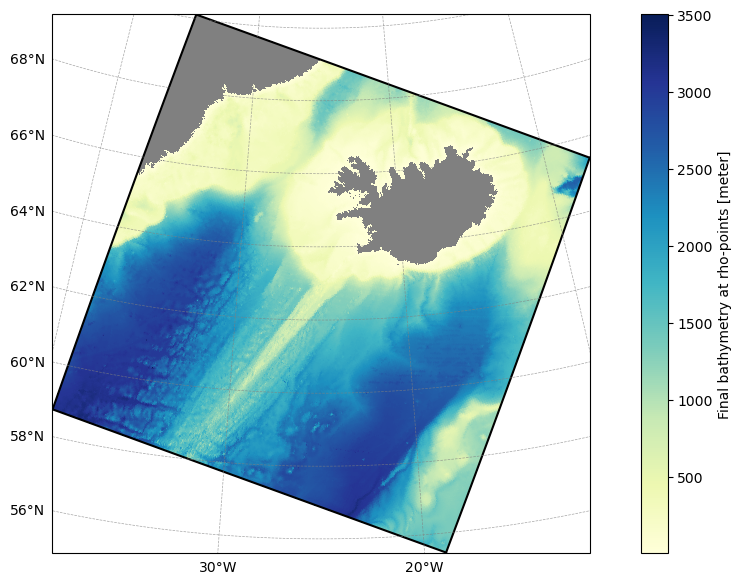

In [7]:
grid.plot()


In [20]:
filepath = project+model_name+'_grid.nc'

In [21]:
grid.save(filepath)

2025-10-03 14:57:16 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_grid.nc


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_grid.nc')]

In [22]:
tpxo_path = datasets+"TPXO/TPXO10.v2/"
tpxo_dict = {
    "grid": tpxo_path + "grid_tpxo10v2.nc",
    "h": tpxo_path + "h_tpxo10.v2.nc",
    "u": tpxo_path + "u_tpxo10.v2.nc",
}

Next, we set up tidal forcing:

In [23]:
from roms_tools import TidalForcing

In [24]:
from datetime import datetime

In [25]:
model_reference_date = datetime(2000, 1, 1)

In [26]:

tidal_forcing = TidalForcing(
    grid=grid,
    source={"name": "TPXO", "path": tpxo_dict},
    ntides=15,  # Number of constituents to consider <= 15. Default is 10.
    model_reference_date=model_reference_date,  # Model reference date. Default is January 1, 2000.
    use_dask=True
)

2025-10-03 14:57:20 - INFO - Applying 2D horizontal fill to the source data before regridding.
2025-10-03 14:57:23 - INFO - Applying 2D horizontal fill to the source data before regridding.
2025-10-03 14:57:23 - INFO - Applying 2D horizontal fill to the source data before regridding.
2025-10-03 14:57:24 - INFO - Applying 2D horizontal fill to the source data before regridding.


In [27]:
filepath = project+model_name+"_tides.nc"

In [28]:
%time tidal_forcing.save(filepath)

2025-10-03 14:57:25 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_tides.nc


[########################################] | 100% Completed | 7.69 ss
CPU times: user 3min 15s, sys: 1.28 s, total: 3min 17s
Wall time: 7.8 s


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_tides.nc')]

For the surface forcing, we use ERA5 plus the unified BGC dataset

In [29]:
from roms_tools import Grid, SurfaceForcing

In [30]:
start_time = datetime(2024, 1, 1)
end_time = datetime(2024, 6, 1)

In [31]:
surface_forcing_kwargs = {
    "grid": grid,
    "start_time": start_time,
    "end_time": end_time,
    "type": "physics",
    "model_reference_date": datetime(2000, 1, 1), # this is the default
}

In [32]:
%%time

surface_forcing = SurfaceForcing(
    **surface_forcing_kwargs,
    source={"name": "ERA5"},
    use_dask=True,
)

2025-10-03 14:57:33 - INFO - No path specified for ERA5 source; defaulting to ARCO ERA5 dataset on Google Cloud.
2025-10-03 14:59:11 - INFO - Data will be interpolated onto the grid coarsened by factor 2. Remember to set `interp_frc = 1` in your `bulk_frc.opt` ROMS option file.
2025-10-03 14:59:11 - INFO - Applying 2D horizontal fill to the source data before regridding.
2025-10-03 14:59:14 - INFO - Applying 2D horizontal fill to the source data before regridding.


CPU times: user 2min 59s, sys: 8.2 s, total: 3min 8s
Wall time: 2min 35s


[########################################] | 100% Completed | 303.47 ms


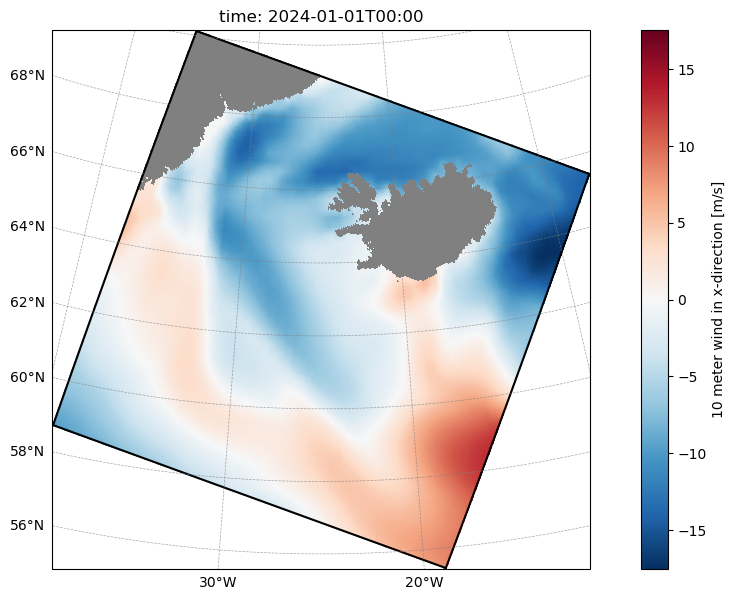

In [33]:
surface_forcing.plot("uwnd", time=0)

In [34]:
#cesm_bgc_path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-surface_lowres_regridded.nc"
unified_bgc_path = datasets+"UNIFIED/BGCdataset.nc"

In [35]:
%%time

unified_bgc_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "UNIFIED", "path": unified_bgc_path, "climatology": True},
    type="bgc",
    use_dask=True,
)

2025-10-03 15:00:12 - INFO - Data will be interpolated onto the grid coarsened by factor 2. Remember to set `interp_frc = 1` in your `bgc.opt` ROMS option file.
2025-10-03 15:00:12 - INFO - 2D horizontal fill is skipped because source data already contains filled values.


CPU times: user 142 ms, sys: 11 ms, total: 153 ms
Wall time: 301 ms


In [36]:
filepath = project+model_name+"_surface_forcing2024.nc"

In [37]:
%time surface_forcing.save(filepath)

2025-10-03 15:00:14 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202401.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202402.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202403.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202404.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202405.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202406.nc


[########################################] | 100% Completed | 147.59 s
[########################################] | 100% Completed | 139.10 s
[########################################] | 100% Completed | 162.77 s
[########################################] | 100% Completed | 155.81 s
[########################################] | 100% Completed | 158.63 s
[########################################] | 100% Completed | 519.49 ms
CPU times: user 5h 37min 35s, sys: 2min 16s, total: 5h 39min 52s
Wall time: 14min 4s


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202401.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202402.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202403.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202404.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202405.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_surface_forcing2024_202406.nc')]

In [38]:
filepath = project+model_name+"_bgc_surface_forcing.nc"

In [39]:
%time unified_bgc_surface_forcing.save(filepath)

2025-10-03 15:14:16 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_bgc_surface_forcing_clim.nc


[########################################] | 100% Completed | 203.94 ms
CPU times: user 200 ms, sys: 10.8 ms, total: 211 ms
Wall time: 242 ms


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_bgc_surface_forcing_clim.nc')]

Next we generate the initial file

In [40]:
from roms_tools import Grid, InitialConditions

In [41]:
from datetime import datetime

In [42]:
ini_time = datetime(2024, 1, 5)

In [43]:
path = datasets+"GLORYS/ICELAND_DOMAIN/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-05_no_depth_zos.nc"

In [44]:
%%time

initial_conditions_with_unified_bgc = InitialConditions(
    grid=grid,
    ini_time=ini_time,
    source={"name": "GLORYS", "path": path},
    bgc_source={
        "name": "UNIFIED",
        "path": unified_bgc_path,
        "climatology": True,
    },  # bgc_source is optional
    model_reference_date=datetime(2000, 1, 1), # this is the default
    use_dask=True,
)

2025-10-03 15:14:16 - INFO - Sea surface height will NOT be used to adjust depth coordinates.
2025-10-03 15:14:16 - INFO - Selected time entry closest to the specified start_time (2024-01-05 00:00:00) within the range [2024-01-05 00:00:00, 2024-01-06 00:00:00]: ['2024-01-05T00:00:00.000000000']
2025-10-03 15:14:16 - INFO - Applying 2D horizontal fill to the source data before regridding.
2025-10-03 15:14:18 - INFO - 2D horizontal fill is skipped because source data already contains filled values.


CPU times: user 3min 16s, sys: 1min 52s, total: 5min 9s
Wall time: 16.8 s


In [45]:
filepath = project+model_name+"_initial_conditions.nc"

In [46]:
%time initial_conditions_with_unified_bgc.save(filepath)

2025-10-03 15:14:33 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_initial_conditions.nc


[########################################] | 100% Completed | 190.02 s
CPU times: user 41min 19s, sys: 17min 23s, total: 58min 42s
Wall time: 3min 13s


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_initial_conditions.nc')]

In [47]:
glorys_path = [
    datasets+"/GLORYS/ICELAND_DOMAIN/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-*_no_depth_zos.nc"]

In [48]:
#glorys_path = [
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-04_no_depth_zos.nc",  # include data from day before start time
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-05_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-06_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-07_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-08_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-09_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-10_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-11_no_depth_zos.nc",  # include data from day after end time
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-12_no_depth_zos.nc", 
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-13_no_depth_zos.nc", 
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-14_no_depth_zos.nc",  # include data from day before start time
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-15_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-16_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-17_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-18_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-19_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-20_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-21_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-22_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-23_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-24_no_depth_zos.nc",  # include data from day before start time
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-25_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-26_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-27_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-28_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-29_no_depth_zos.nc",
#    "/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-30_no_depth_zos.nc",
#    #"/global/cfs/cdirs/m4632/uheede/GLORYS/2024/cmems_mod_glo_phy_myint_0.083deg_P1D-m_multi-vars_52.50W-2.67E_44.33N-74.42N_1.54-3992.48m_2024-01-31_no_depth_zos.nc"
#]

In [49]:
from roms_tools import Grid, BoundaryForcing

In [50]:
start_time = datetime(2024, 1, 1)
end_time = datetime(2024, 6, 30)

In [51]:
%%time

boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    boundaries={
        "south": True,
        "east": True,
        "north": True,  
        "west": True,
    },
    source={"name": "GLORYS", "path": glorys_path},
    type="physics",  # "physics" or "bgc"; default is "physics"
    model_reference_date=datetime(2000, 1, 1), # this is the default
    use_dask=True,
)

2025-10-03 15:17:46 - INFO - Sea surface height will NOT be used to adjust depth coordinates.
2025-10-03 15:18:48 - WARNING - No records found at or after the end_time.
2025-10-03 15:18:48 - INFO - Applying 1D horizontal fill to southern boundary.
2025-10-03 15:18:50 - INFO - Applying 1D horizontal fill to eastern boundary.
2025-10-03 15:18:51 - INFO - Applying 1D horizontal fill to northern boundary.
2025-10-03 15:18:51 - INFO - Applying 1D horizontal fill to western boundary.


CPU times: user 7.14 s, sys: 1.49 s, total: 8.63 s
Wall time: 1min 6s


In [52]:
%%time

unified_bgc_boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    boundaries={
        "south": True,
        "east": True,
        "north": True,  
        "west": True,
    },
    source={"name": "UNIFIED", "path": unified_bgc_path, "climatology": True},
    type="bgc",
    use_dask=True,
)

2025-10-03 15:18:53 - INFO - Sea surface height will NOT be used to adjust depth coordinates.


CPU times: user 6.56 s, sys: 140 ms, total: 6.7 s
Wall time: 6.89 s


In [53]:
filepath = project+model_name+"_bgc_boundary_forcing_2024.nc"
%time unified_bgc_boundary_forcing.save(filepath)


2025-10-03 15:19:00 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_bgc_boundary_forcing_2024_clim.nc


[########################################] | 100% Completed | 42.01 s
CPU times: user 1min 17s, sys: 45.6 s, total: 2min 2s
Wall time: 43 s


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_bgc_boundary_forcing_2024_clim.nc')]

In [54]:
filepath = project+model_name+"_boundary_forcing_2024.nc"
%time boundary_forcing.save(filepath, group=True)

2025-10-03 15:19:44 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_boundary_forcing_2024_202401.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_boundary_forcing_2024_202402.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_boundary_forcing_2024_202403.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_boundary_forcing_2024_202404.nc
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_boundary_forcing_2024_202405.nc


[########################################] | 100% Completed | 19.18 s
[########################################] | 100% Completed | 15.27 s
[########################################] | 100% Completed | 18.79 s
[########################################] | 100% Completed | 17.27 s
[########################################] | 100% Completed | 17.93 s
CPU times: user 2min 9s, sys: 14.4 s, total: 2min 23s
Wall time: 1min 34s


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_boundary_forcing_2024_202401.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_boundary_forcing_2024_202402.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_boundary_forcing_2024_202403.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_boundary_forcing_2024_202404.nc'),
 PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland0_boundary_forcing_2024_202405.nc')]

In [55]:
from roms_tools import Grid, ChildGrid

In [56]:
parent_grid = grid

In [57]:
child_grid_parameters = {
    "nx": 512,
    "ny": 512,
    "size_x": 384,
    "size_y": 384,
    "center_lon": -24,
    "center_lat": 64.9,
    "rot": 0,
    "topography_source": {
        "name": "SRTM15",
        "path": datasets+"SRTM15/SRTM15_V2.6.nc"},
    "N":60  # number of vertical layers
}

In [58]:
child_grid = ChildGrid(
    **child_grid_parameters,
    parent_grid=parent_grid,
    boundaries={
        "south": True,
        "east": True,
        "north": True,
        "west": True,
    },  # this is the default
    metadata={"prefix": "child", "period": 900.0}  # this is the default
)

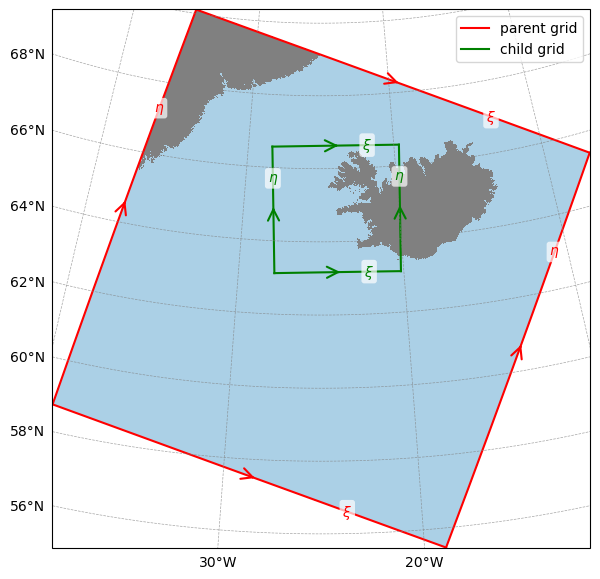

In [59]:
child_grid.plot_nesting(with_dim_names=True)

In [60]:
filepath = project+child_name+"_grid.nc"
child_grid.save(filepath=filepath)

2025-10-03 15:24:34 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland1_grid.nc


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland1_grid.nc')]

In [61]:
filepath_nesting = project+child_name+"_edata.nc"

In [62]:
child_grid.save_nesting(filepath=filepath_nesting)

2025-10-03 15:24:34 - INFO - Writing the following NetCDF files:
/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland1_edata.nc


[PosixPath('/anvil/projects/x-ees250129/x-uheede/INPUT_files/Iceland0_MARBL_2024/Iceland1_edata.nc')]

In [63]:
from roms_tools import partition_netcdf

In [64]:
%time partition_netcdf(project+model_name+'_grid.nc', np_eta=16, np_xi=16, output_dir='/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT')

CPU times: user 6.15 s, sys: 1.68 s, total: 7.84 s
Wall time: 30.2 s


[PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.000.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.001.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.002.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.003.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.004.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.005.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.006.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.007.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.008.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.009.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.010.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_grid.011.nc'),
 PosixPath('/home/x-uheede/S

In [65]:
%time partition_netcdf(project+model_name+'_tides.nc', np_eta=16, np_xi=16, output_dir='/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT')

CPU times: user 4.03 s, sys: 960 ms, total: 4.99 s
Wall time: 38.9 s


[PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.000.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.001.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.002.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.003.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.004.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.005.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.006.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.007.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.008.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.009.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.010.nc'),
 PosixPath('/home/x-uheede/S/Iceland0_MARBL_2024/P_INPUT/Iceland0_tides.011.nc'),
 PosixPath('/hom